<a href="https://colab.research.google.com/github/sayakpaul/SimSiam-TF/blob/main/SimSiam_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook evaluates the frozen features of a ResNet50 pre-trained (50 epochs of pre-training) using the [SimSiam method](https://arxiv.org/abs/2011.10566). You can refer to the [pre-training notebook here](https://github.com/sayakpaul/SimSiam-TF/blob/main/SimSiam_Pre_training.ipynb). Following evaluation methods have been used - 

* Linear evaluation of the frozen features

*Please note that to keep this minimal I did not follow the original hyperparameter configurations rigorously.*  

## Initial setup

In [ ]:
!nvidia-smi

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
#import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os

#tf.random.set_seed(666)
#np.random.seed(666)

## Dataset collection & preparation

The following code is referred from [here](https://github.com/ayulockin/SwAV-TF/blob/master/linear_evaluation/Linear_Evaluation_10_Epochs.ipynb). 

In [ ]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)
print(train_ds)

In [3]:
BATCH_SIZE = 16

training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'TCGA_Data/train1/',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'rgb',
    batch_size = 16,
    image_size = (224, 224)
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'TCGA_Data/test/',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'rgb',
    batch_size = 16,
    image_size = (224, 224)
)

Found 5247 files belonging to 4 classes.
Found 1861 files belonging to 4 classes.


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16

@tf.function
def scale_resize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224)) # Resizing to highest resolution used while training swav
    return (image, label)

training_ds = (
    training_ds
    #.map(scale_resize_image, num_parallel_calls=AUTO)
    #.batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validation_ds = (
    validation_ds
    #.map(scale_resize_image, num_parallel_calls=AUTO)
    #.batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Utility functions

In [4]:
def get_encoder():
    base_model = tf.keras.applications.ResNet50(include_top=False,
        weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True

    inputs = tf.keras.layers.Input((224, 224, 3))
    x = base_model(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(2048, activation='relu', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    z = tf.keras.layers.Dense(2048)(x)

    f = tf.keras.Model(inputs, z)

    return f

In [5]:
get_encoder().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              4194304   
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2048)              419635

In [6]:
# We now load up the pre-trained weights
projection = get_encoder()
projection.load_weights('projection_TCGA.h5')

# Create a sub-model for extracting features
rn50 = tf.keras.Model(projection.input, projection.layers[2].output)
rn50.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [7]:
def get_linear_classifier(feature_backbone, trainable=False):
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    
    feature_backbone.trainable = trainable
    x = feature_backbone(inputs, training=False)
    outputs = tf.keras.layers.Dense(4, activation="softmax", )(x)
    linear_model = tf.keras.Model(inputs, outputs)

    return linear_model

In [8]:
get_linear_classifier(rn50).summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model_2 (Functional)        (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
def plot_progress(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()

## Linear evaluation

In [10]:
# Early Stopping to prevent overfitting
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=4, verbose=2, 
                                                 restore_best_weights=True)

Epoch 1/100
328/328 [==============================] - 27s 69ms/step - loss: 1.3001 - accuracy: 0.4202 - val_loss: 1.2306 - val_accuracy: 0.4073
Epoch 2/100
328/328 [==============================] - 21s 62ms/step - loss: 1.1744 - accuracy: 0.5035 - val_loss: 1.0132 - val_accuracy: 0.5723
Epoch 3/100
328/328 [==============================] - 20s 62ms/step - loss: 1.0713 - accuracy: 0.5550 - val_loss: 1.2436 - val_accuracy: 0.5142
Epoch 4/100
328/328 [==============================] - 21s 63ms/step - loss: 1.0296 - accuracy: 0.5822 - val_loss: 0.9205 - val_accuracy: 0.6212: 10s - los - ETA: 7s - - ETA: 5s - loss: 1.0267 - accura - ETA: 3s - loss: 1.0320 - accuracy - ETA: 2s - loss: 1 - ETA: 
Epoch 5/100
328/328 [==============================] - 21s 63ms/step - loss: 0.9820 - accuracy: 0.6005 - val_loss: 0.9635 - val_accuracy: 0.6249
Epoch 6/100
328/328 [==============================] - 21s 65ms/step - loss: 0.9215 - accuracy: 0.6337 - val_loss: 1.0694 - val_accuracy: 0.6034cy:  - ETA

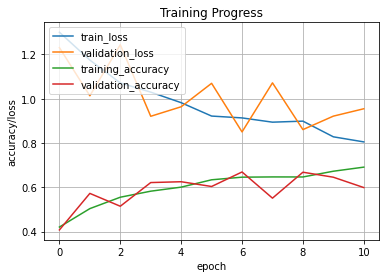

In [11]:
# Get linear model and compile
tf.keras.backend.clear_session()
model = get_linear_classifier(rn50)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")

# Train 
history = model.fit(training_ds,
                 validation_data=validation_ds,
                 epochs=100,
                 callbacks=[early_stopper])
plot_progress(history)

In [12]:
_, acc = model.evaluate(validation_ds)
print('Validation accuracy:', round(acc*100, 2))

117/117 [==============================] - 6s 49ms/step - loss: 0.8499 - accuracy: 0.6690
Validation accuracy: 66.9


For a minimal implementation the scores aren't that bad. 